# Style Net
We are going to implement the Style Net network from Gatys et al.
https://arxiv.org/pdf/1508.06576.pdf

<a name="network"></a>
## Network

Let's reset the graph and load up a pretrained network.  We will be using VGG16, similarly to the original paper, although any other network could be used, some of them included in the libs folder.

In [22]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from libs import vgg16
import os

import warnings
warnings.filterwarnings('ignore')

In [23]:
tf.reset_default_graph()
net = vgg16.get_vgg_model()

try adding PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python to environment.  e.g.:
PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python ipython
See here for info: https://github.com/tensorflow/tensorflow/issues/582


In [24]:
# Let's explicity use the CPU, since we don't gain anything using the GPU
# when doing Style Transfer (it's only a single image, benefits come with many images).
device = '/cpu:0'

# We'll now explicitly create a graph
g = tf.Graph()

Let's now import the graph definition into our newly created Graph using a context manager and specifying that we want to use the CPU.

In [25]:
# Create Session:
# We'll be explicit about using the CPU instead of a GPU.
with tf.Session(graph=g) as sess, g.device(device):
    # Now load the graph_def, which defines operations and their values into 'g'
    tf.import_graph_def(net['graph_def'], name='net')

Let's then grab the names of every operation in our network:

In [27]:
names = [op.name for op in g.get_operations()]

Now we need an image for our content image and another one for our style image:  
For the content I will select a picture of myself and for the style a glitch art image.

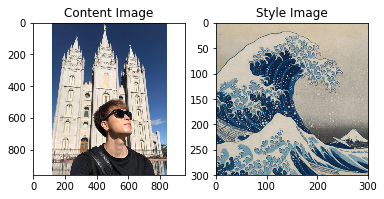

In [28]:
content_image_path = 'dongwonshin.jpg'
style_image_path = 'style.jpg'
style_og = plt.imread(style_image_path)
content_og = plt.imread(content_image_path)[..., :3]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(content_og)
axs[0].set_title('Content Image')
axs[0].grid('off')
axs[1].imshow(style_og)
axs[1].set_title('Style Image')
axs[1].grid('off')

In [29]:
#Let's preprocess the images to match the network inputs
content_img = net['preprocess'](content_og)[np.newaxis]
style_img = net['preprocess'](style_og)[np.newaxis]

In [33]:
# Grab the tensor defining the input to the network
x = g.get_tensor_by_name(names[0] + ':0')

## Content Features

We're going to need to find the layer or layers we want to use to help us define our "content loss".  In the case of VGG, we will use the 4th convolutional layer.

In [34]:
print(names)

['net/images', 'net/mul/y', 'net/mul', 'net/split/split_dim', 'net/split', 'net/sub/y', 'net/sub', 'net/sub_1/y', 'net/sub_1', 'net/sub_2/y', 'net/sub_2', 'net/concat/concat_dim', 'net/concat', 'net/conv1_1/filter', 'net/conv1_1/Conv2D', 'net/conv1_1/biases', 'net/conv1_1/BiasAdd', 'net/conv1_1/conv1_1', 'net/conv1_2/filter', 'net/conv1_2/Conv2D', 'net/conv1_2/biases', 'net/conv1_2/BiasAdd', 'net/conv1_2/conv1_2', 'net/pool1', 'net/conv2_1/filter', 'net/conv2_1/Conv2D', 'net/conv2_1/biases', 'net/conv2_1/BiasAdd', 'net/conv2_1/conv2_1', 'net/conv2_2/filter', 'net/conv2_2/Conv2D', 'net/conv2_2/biases', 'net/conv2_2/BiasAdd', 'net/conv2_2/conv2_2', 'net/pool2', 'net/conv3_1/filter', 'net/conv3_1/Conv2D', 'net/conv3_1/biases', 'net/conv3_1/BiasAdd', 'net/conv3_1/conv3_1', 'net/conv3_2/filter', 'net/conv3_2/Conv2D', 'net/conv3_2/biases', 'net/conv3_2/BiasAdd', 'net/conv3_2/conv3_2', 'net/conv3_3/filter', 'net/conv3_3/Conv2D', 'net/conv3_3/biases', 'net/conv3_3/BiasAdd', 'net/conv3_3/conv3_

Pick a layer for using for the content features.

In [35]:
content_layer = 'net/conv3_2/conv3_2:0'

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    content_features = g.get_tensor_by_name(content_layer).eval(
            session=sess,
            feed_dict={x: content_img})

## Style Features

Let's do the same thing now for the style features.  We'll use more than 1 layer though so we'll append all the features in a list.


In [11]:
# Experiment with different layers and layer subsets.  You'll need to change these
# if you use a different network!
style_layers = ['net/conv1_1/conv1_1:0',
                'net/conv2_1/conv2_1:0',
                'net/conv3_1/conv3_1:0',
                'net/conv4_1/conv4_1:0',
                'net/conv5_1/conv5_1:0']
style_activations = []

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    for style_i in style_layers:
        style_activation_i = g.get_tensor_by_name(style_i).eval(
            feed_dict={x: style_img})
        style_activations.append(style_activation_i)

Now we find the gram matrix which we'll use to optimize our features.

In [12]:
style_features = []
for style_activation_i in style_activations:
    s_i = np.reshape(style_activation_i, [-1, style_activation_i.shape[-1]])
    gram_matrix = np.matmul(s_i.T, s_i) / s_i.size
    style_features.append(gram_matrix.astype(np.float32))

## Remapping the Input

Now, we just have to change the input to the network to become "trainable".  Instead of a placeholder, we'll have a `tf.Variable`, which allows gradients to be backpropagated and modify the input image.


In [36]:
tf.reset_default_graph()
g = tf.Graph()

# Get the network again
net = vgg16.get_vgg_model()

# Load up a session which we'll use to import the graph into.
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    net_input = tf.Variable(content_img)
    
    # Now we load the network again, but this time replacing our placeholder
    # with the trainable tf.Variable
    tf.import_graph_def(
        net['graph_def'],
        name='net',
        input_map={'images:0': net_input})

try adding PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python to environment.  e.g.:
PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python ipython
See here for info: https://github.com/tensorflow/tensorflow/issues/582


## Content Loss

Find the l2 loss between our content layer features.

In [37]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    content_loss = tf.nn.l2_loss((g.get_tensor_by_name(content_layer) - content_features) /
                                 content_features.size)

## Style Loss

Instead of straight l2 loss on the raw feature activations, we're going to calculate the gram matrix and find the loss between these.  Intuitively, this is finding what is common across all convolution filters, and trying to enforce the commonality between the synthesis and style image's gram matrix.

In [38]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    style_loss = np.float32(0.0)
    for style_layer_i, style_gram_i in zip(style_layers, style_features):
        layer_i = g.get_tensor_by_name(style_layer_i)
        layer_shape = layer_i.get_shape().as_list()
        layer_size = layer_shape[1] * layer_shape[2] * layer_shape[3]
        layer_flat = tf.reshape(layer_i, [-1, layer_shape[3]])
        gram_matrix = tf.matmul(tf.transpose(layer_flat), layer_flat) / layer_size
        style_loss = tf.add(style_loss, tf.nn.l2_loss((gram_matrix - style_gram_i) / np.float32(style_gram_i.size)))

## Total Variation Loss

We'll also enforce some smoothness using a total variation loss.

In [44]:
def total_variation_loss(x):
    h, w = x.get_shape().as_list()[1], x.get_shape().as_list()[1]
    dx = tf.square(x[:, :h-1, :w-1, :] - x[:, :h-1, 1:, :])
    dy = tf.square(x[:, :h-1, :w-1, :] - x[:, 1:, :w-1, :])
    return tf.reduce_sum(tf.pow(dx + dy, 1.25))

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    tv_loss = total_variation_loss(net_input)

## Training

Let's just combine our three loss measures and stick it in an optimizer.

In [45]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    # Tune loss weights to obtain different results (e.g. enhance content vs enhance style)
    loss = 5.0 * content_loss + 1.0 * style_loss + 0.001 * tv_loss
    optimizer = tf.train.AdamOptimizer(0.05).minimize(loss)

Let's now iterate:

In [46]:
# If we want to create a gif to visualize the changes over iterations
from libs import gif
make_gif = True

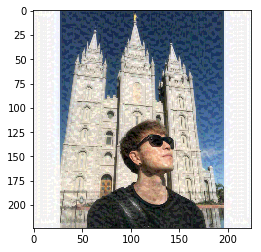

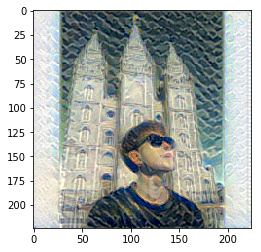

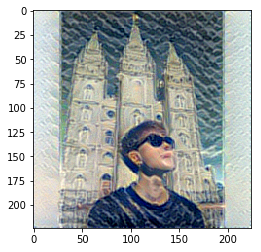

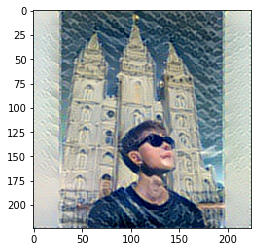

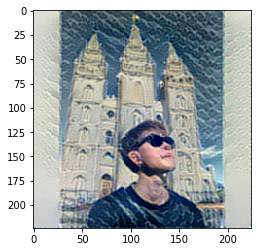

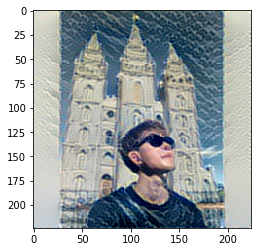

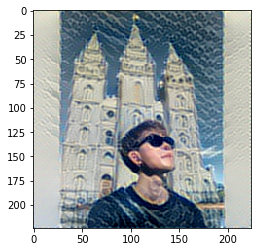

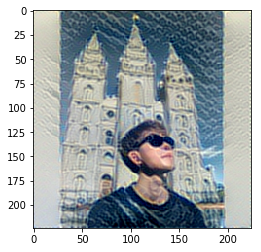

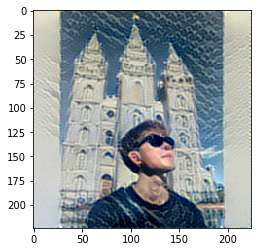

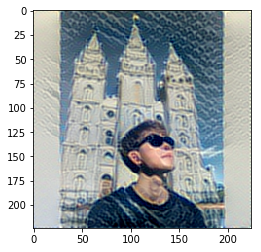

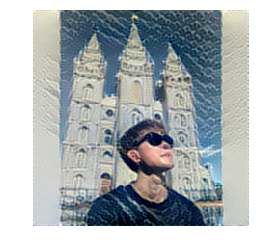

In [47]:
imgs = []
n_iterations = 100

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    sess.run(tf.global_variables_initializer())

    og_img = net_input.eval()
    
    for it_i in range(n_iterations):
        _, this_loss, synth = sess.run([optimizer, loss, net_input])
#         print("%d: %f, (%f - %f)" % (it_i, this_loss, np.min(synth), np.max(synth)))
        if it_i % 10 == 0:
            m = vgg16.deprocess(synth[0])
            imgs.append(m)
            plt.imshow(m)
            plt.show()
    if make_gif:
        gif.build_gif(imgs, saveto='stylenet.gif')

In [48]:
#Display gif
import IPython.display as ipyd
ipyd.Image(url='stylenet.gif', height=300, width=300)

# More style transfer exampels
http://www.kylemcdonald.net/stylestudies/

http://sanghyukchun.github.io/92/

https://github.com/Curt-Park/style_transfer_keras

In [49]:
tf.__version__

'1.11.0'